Aims:
1. Finalizing data processing/cleaning function.
2. Explortatory Data Analysis (EDA)

Before heading into EDA, data processing function needs 
to be modified for negation, url link structure variability,
and Twitter ID variability.

Negation words are split into two parts. The 't' after the apostrophe vanishes 
when I filter the r tokens with length >1 syllable. This means "can't" = "can".

Some of the URL links don't start with "http" as initially assumed. Some people paste 
"www.aaa.com" as a link. Also, another fix is to add symbols such as "=", "_", "~", 
etc. to URL editor.

Lastly, Twitter ID's are modified further to include underscore symbol as character
that can be used with ID. 

Updated cleaning function in the following order:
    
1. Souping
2. BOM removing
3. url address('http:'pattern), twitter ID removing
4. url address('www.'pattern) removing
5. lower-case
6. negation handling
7. removing numbers and special char's
8. tokenizing and joining

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
import re
from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer
tok = WordPunctTokenizer()

pat1 = r'@[A-Za-z0-9_]+'
pat2 = r'https?://[^ ]+'
combined_pat = r'|'.join((pat1, pat2))
www_pat = r'www.[^ ]+'
negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}
neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')

def tweet_cleaner_updated(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    try:
        bom_removed = souped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        bom_removed = souped
    stripped = re.sub(combined_pat, '', bom_removed)
    stripped = re.sub(www_pat, '', stripped)
    lower_case = stripped.lower()
    neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], lower_case)
    letters_only = re.sub("[^a-zA-Z]", " ", neg_handled)
    # Two lines above, during the letters_only process, unnecessay white spaces were created.
    # To remove these white space, tokenize and join together.
    words = [x for x  in tok.tokenize(letters_only) if len(x) > 1]
    return (" ".join(words)).strip()

In [4]:
df = pd.read_csv("training.1600000.processed.noemoticon.csv",header=None,usecols=[0,5],names=['sentiment','text'])
df['sentiment'] = df['sentiment'].map({0:0, 4:1})
df.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [5]:
%%time
print "Cleaning the tweets...\n"
clean_tweets_texts = []
for i in xrange(0, len(df)):
    if( (i+1)%100000 == 0 ):
        print "Tweets %d of %d has been processed" % (i+1, len(df) )
    clean_tweets_texts.append(tweet_cleaner_updated(df['text'][i]))

Cleaning the tweets...



/Users/mindyng/anaconda/lib/python2.7/encodings/utf_8_sig.py:19: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if input[:3] == codecs.BOM_UTF8:


Tweets 100000 of 1600000 has been processed
Tweets 200000 of 1600000 has been processed
Tweets 300000 of 1600000 has been processed
Tweets 400000 of 1600000 has been processed
Tweets 500000 of 1600000 has been processed
Tweets 600000 of 1600000 has been processed
Tweets 700000 of 1600000 has been processed
Tweets 800000 of 1600000 has been processed
Tweets 900000 of 1600000 has been processed
Tweets 1000000 of 1600000 has been processed
Tweets 1100000 of 1600000 has been processed
Tweets 1200000 of 1600000 has been processed
Tweets 1300000 of 1600000 has been processed
Tweets 1400000 of 1600000 has been processed
Tweets 1500000 of 1600000 has been processed
Tweets 1600000 of 1600000 has been processed
CPU times: user 12min 13s, sys: 41.1 s, total: 12min 54s
Wall time: 13min 9s


In [6]:
clean_df = pd.DataFrame(clean_tweets_texts, columns = ['text'])
clean_df['target'] = df.sentiment
clean_df.to_csv('clean_tweet.csv', encoding = 'utf-8')

In [7]:
csv = 'clean_tweet.csv'
my_df = pd.read_csv(csv, index_col = 0)
my_df.head()

/Users/mindyng/anaconda/lib/python2.7/site-packages/numpy/lib/arraysetops.py:395: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,text,target
0,awww that bummer you shoulda got david carr of...,0
1,is upset that he can not update his facebook b...,0
2,dived many times for the ball managed to save ...,0
3,my whole body feels itchy and like its on fire,0
4,no it not behaving at all mad why am here beca...,0


After re-cleaning the data/text with the new function, took another exploratory round with the 
newly cleaned text.

In [8]:
my_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
text      1596019 non-null object
target    1600000 non-null int64
dtypes: int64(1), object(1)
memory usage: 36.6+ MB


In [9]:
my_df[my_df.isnull().any(axis=1)].head()

,text,target
208,NaN,0
249,NaN,0
282,NaN,0
398,NaN,0
430,NaN,0


In [10]:
np.sum(my_df.isnull().any(axis=1))

3981

In [11]:
my_df.isnull().any(axis=0)

text       True
target    False
dtype: bool

It appears there are a total of 3981 null entries post text-processing. However, at the beginning, prior to cleaning the text, there were no null values. The null values must have 
appeared during cleaning text procedure.

In [12]:
pwd

u'/Users/mindyng/Desktop/twitter_sentiment_analysis_part2-master'

In [13]:
df = pd.read_csv("training.1600000.processed.noemoticon.csv", header = None)
df.iloc[my_df[my_df.isnull().any(axis=1)].index,:].head()

,0,1,2,3,4,5
208,0,1467863072,Mon Apr 06 22:33:25 PDT 2009,NO_QUERY,Artiel87,@mandayyy
249,0,1467874569,Mon Apr 06 22:36:27 PDT 2009,NO_QUERY,Artiel87,@mandayyy
282,0,1467881474,Mon Apr 06 22:38:20 PDT 2009,NO_QUERY,__Susan__,@ITS_NEMESIS -------
398,0,1467912842,Mon Apr 06 22:46:53 PDT 2009,NO_QUERY,KimberlyKane,@danadearmond
430,0,1467919452,Mon Apr 06 22:48:48 PDT 2009,NO_QUERY,jtmal0723,@anistorm


By looking at the original data, can see that only text was either user id or possibly URL address. Regardless of where these values came from, all null rows will be dropped.

In [14]:
my_df.dropna(inplace = True)
my_df.reset_index(drop= True, inplace=True)
my_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1596019 entries, 0 to 1596018
Data columns (total 2 columns):
text      1596019 non-null object
target    1596019 non-null int64
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


**Word Cloud**

A Word cloud is a bunch of words that vary in size dependent upon word's frequency. There is
some heated debate over it because some people say that Word Cloud is a crudy way of examining
body of text. 

In [15]:
neg_tweets = my_df[my_df.target == 0]
neg_string = []
for t in neg_tweets.text:
    neg_string.append(t)
neg_string = pd.Series(neg_string).str.cat(sep=' ')

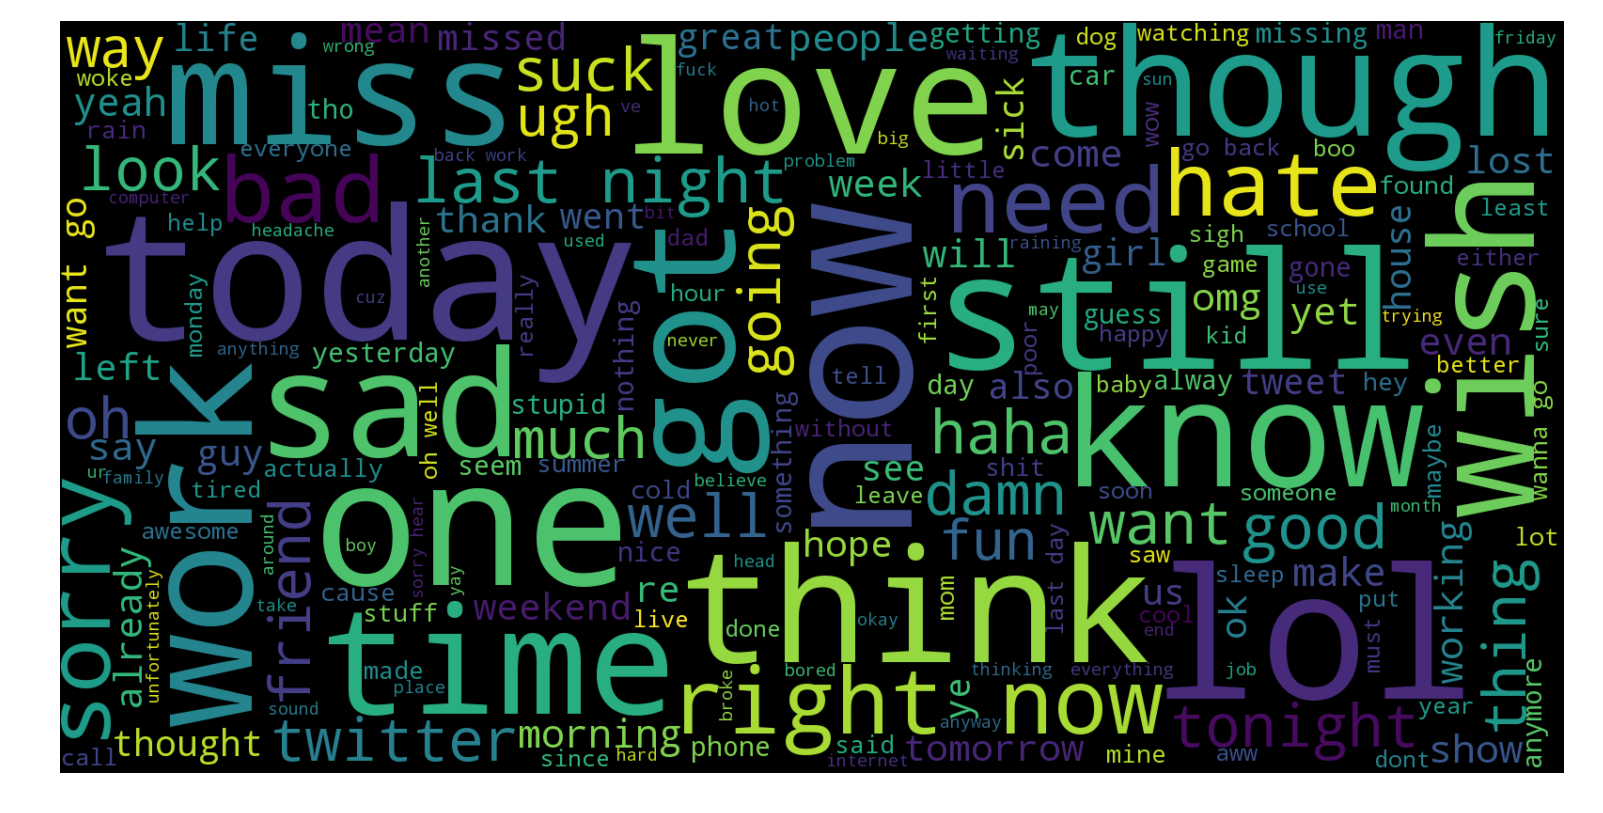

In [16]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(neg_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Not surprisingly that many of the most frequent words are neutral, such as, "today", "though", "now", "time" and "one". Most of the big words are obviously negative such as "sad", "hate", "sorry", "suck". However, the word "love" is huge as well, but it is not a negative sentiment. Let us explore this a little closer.

In [17]:
for t in neg_tweets.text[:200]:
    if 'love' in t:
        print t

ahh ive always wanted to see rent love the soundtrack
meh almost lover is the exception this track gets me depressed every time
awe love you too am here miss you
damn the grind is inspirational and saddening at the same time do not want you to stop cuz like what do much love
missing you babe but as long as your alive happy ya tired my love imma try to sleep hopefully you had headstart
love the french tell people here in the south qtr french and they snarl at me french are beautiful people


It turns out the word "love" is mixed in with negative words that produce overall negative sentiment. Also, sarcasm causes positive words to be mixed with negative words.

In [18]:
pos_tweets = my_df[my_df.target == 1]
pos_string = []
for t in pos_tweets.text:
    pos_string.append(t)
pos_string = pd.Series(pos_string).str.cat(sep=' ')

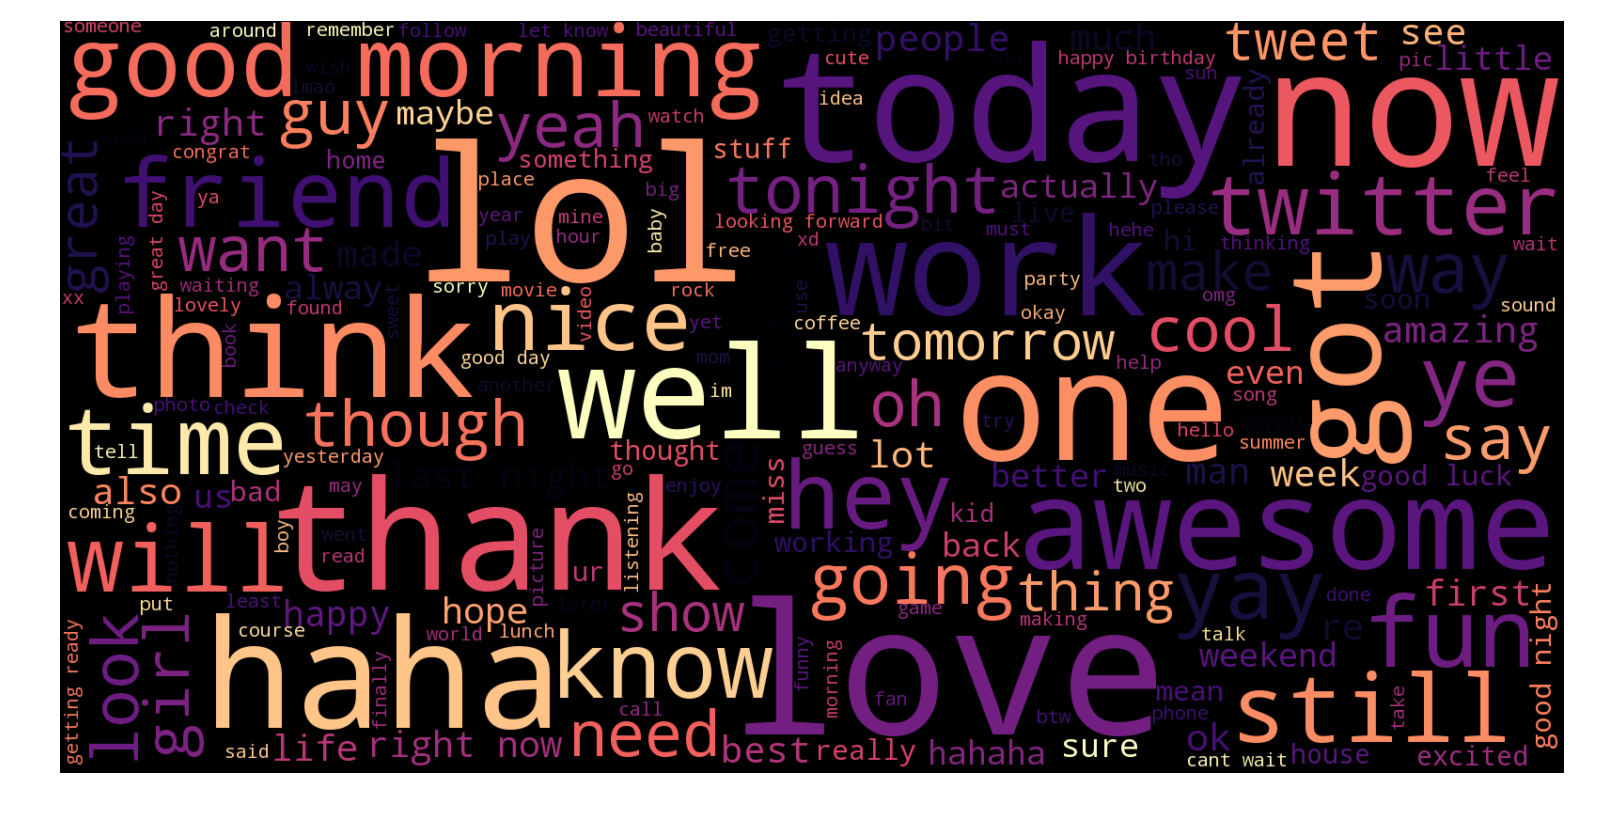

In [19]:
wordcloud = WordCloud(width=1600, height=800,max_font_size=200,colormap='magma').generate(pos_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Neutral words such as "one", "now", "still" appear frequently again. However, positive words, such as "love", "lol", "haha" appear as expected to express positive sentiment. An interesting observation is that "work" is seen as a frequently in negative and positive sentiments. So people see work as negative or positive. Not suprising either. 

In [20]:
del pos_tweets, pos_string, neg_tweets, neg_string, wordcloud, df

**Preparation for Data Viz**

In order to implement some data viz, need term frequency data. What sort of words are in the corpus and how often do they appear? Count vectorizer was used to answer these questions. It calculates term frequencies. The count vectorizer is also for fitting and predicting, but for now, the focus will be on extracting term frequencies.

When using count vectorizer, there are parameter options to use that can eliminate stop words and put a limit on maximum number of terms. These parameters will not be used at this moment in order to get a full picture of the dataset without any modifications. Therefore, count vectorizer is implemented with stop words included and without a limit on maximum number of terms.

In [21]:
from sklearn.feature_extraction.text import CountVectorizer
cvec = CountVectorizer()
cvec.fit(my_df.text)

CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern=u'(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [22]:
len(cvec.get_feature_names())

264936

Count vectorizer came up with 264936 words in the corpus. 

...End Part 2 here!...

In [23]:
neg_doc_matrix = cvec.transform(my_df[my_df.target == 0].text)
pos_doc_matrix = cvec.transform(my_df[my_df.target == 1].text)
neg_tf = np.sum(neg_doc_matrix,axis=0)
pos_tf = np.sum(pos_doc_matrix,axis=0)
neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))
term_freq_df = pd.DataFrame([neg,pos],columns=cvec.get_feature_names()).transpose()

Got term frequency via transforming sparse matrix to a dense one.

In [24]:
term_freq_df.columns = ['negative', 'positive']
term_freq_df['total'] = term_freq_df['negative'] + term_freq_df['positive']
term_freq_df.sort_values(by='total', ascending=False).iloc[:10]

,negative,positive,total
to,313160,252566,565726
the,257836,265998,523834
my,190774,125955,316729
it,157448,147786,305234
and,153958,149642,303600
you,103844,198245,302089
not,194724,86865,281589
is,133435,111191,244626
in,115541,101160,216701
for,98999,117369,216368


In [25]:
len(term_freq_df)

264936

In [26]:
term_freq_df.to_csv('term_freq_df.csv',encoding='utf-8')

**Zipf's Law**

Zipf's Law is first presented by French stenographer Jean-Baptiste Estoup and later named after the American linguist George Kingsley Zipf. Zipf's Law states that a small number of words are used all the time, while the vast majority are used very rarely. There is nothing surprising about this, we know that we use some of the words very frequently, such as "the", "of", etc, and we rarely use the words like "aardvark" (aardvark is an animal species native to Africa). However, what's interesting is that "given some corpus of natural language utterances, the frequency of any word is inversely proportional to its rank in the frequency table. Thus the most frequent word will occur approximately twice as often as the second most frequent word, three times as often as the third most frequent word, etc."

In other words, the rth most frequent word has a frequency f(r) that scales according to $${f(r)} \propto \frac{1}{r^\alpha}$$ for $$\alpha \approx {1}$$
Let's see how the tweet tokens and their frequencies look like on a plot.

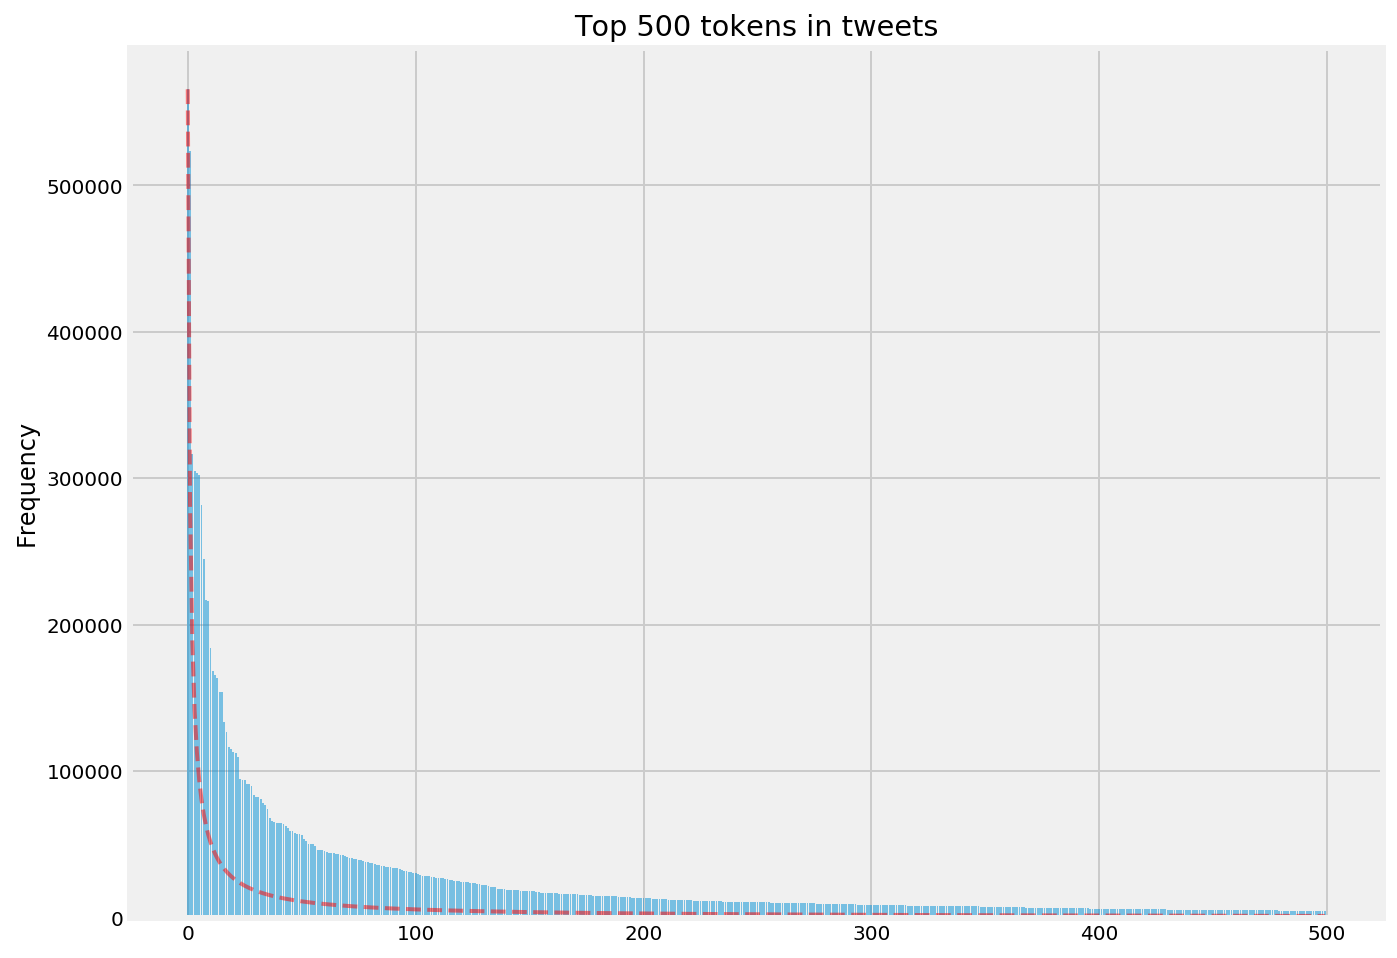

In [27]:
y_pos = np.arange(500)
plt.figure(figsize=(10,8))
s = 1
expected_zipf = [term_freq_df.sort_values(by='total', ascending=False)['total'][0]/(i+1)**s for i in y_pos]
plt.bar(y_pos, term_freq_df.sort_values(by='total', ascending=False)['total'][:500], align='center', alpha=0.5)
plt.plot(y_pos, expected_zipf, color='r', linestyle='--',linewidth=2,alpha=0.5)
plt.ylabel('Frequency')
plt.title('Top 500 tokens in tweets')


On the X-axis is the rank of the frequency from highest rank from left up to 500th rank to the right. Y-axis is the frequency observed in the corpus (in this case, "Sentiment140" dataset). One thing to note is that the actual observations in most cases does not strictly follow Zipf's distribution, but rather follow the trend of "near-Zipfian" distribution.
Even though we can see the plot follows the trend of Zipf's Law, but it looks like it has more area above the expected Zipf curve in higher ranked words.
Another way to plot this is on a log-log graph, with X-axis being log(rank), Y-axis being log(frequency). By plotting on the log-log scale the result will yield roughly linear line on the graph.

/Users/mindyng/anaconda/lib/python2.7/site-packages/pandas/core/indexes/base.py:2477: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  tz=getattr(series.dtype, 'tz', None))


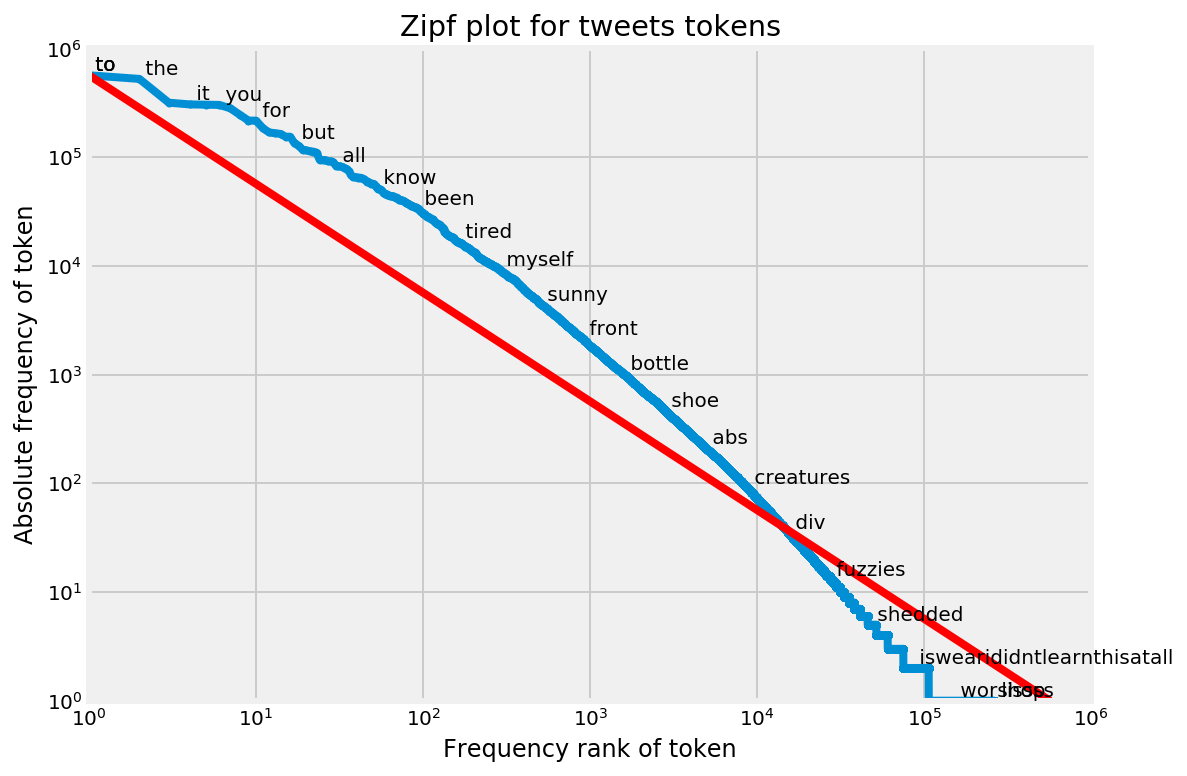

In [28]:
from pylab import *
counts = term_freq_df.total
tokens = term_freq_df.index
ranks = arange(1, len(counts)+1)
indices = argsort(-counts)
frequencies = counts[indices]
plt.figure(figsize=(8,6))
plt.ylim(1,10**6)
plt.xlim(1,10**6)
loglog(ranks, frequencies, marker=".")
plt.plot([1,frequencies[0]],[frequencies[0],1],color='r')
title("Zipf plot for tweets tokens")
xlabel("Frequency rank of token")
ylabel("Absolute frequency of token")
grid(True)
for n in list(logspace(-0.5, log10(len(counts)-2), 25).astype(int)):
    dummy = text(ranks[n], frequencies[n], " " + tokens[indices[n]], 
                 verticalalignment="bottom",
                 horizontalalignment="left")

It is a roughly linear curve, but deviating above the expected line on higher ranked words. At lower ranked words, the actual observation line lies below the expected linear line.

In [30]:
term_freq_df = pd.read_csv('term_freq_df.csv',index_col=0, encoding='utf_8')

Proved that tweet tokens followed "near-Zipfian" distribution. Obsevation from near-Zipfian also begs question if tweet corpus uses frequent words more heavily. Is there statistically significant difference compared to other text corpora.

**Tweets Tokens Viz**

After observing how tokens are distributed across whole corpus, next thing to tackle is how token are distributed across separate sentiment classes: positve and negative. In order to do this, stop words will be eliminated in order to filter out words that may be in both classes and occur frequently. To reduce noise, stop words will be removed. Also, another reduction in noise will be through setting max_features to 10,000 using CountVectorizer.

In [32]:
from sklearn.feature_extraction.text import CountVectorizer
cvec = CountVectorizer(stop_words='english',max_features=10000)
cvec.fit(my_df.text)

CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=10000, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern=u'(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [33]:
document_matrix = cvec.transform(my_df.text)

In [34]:
%%time
neg_batches = np.linspace(0,798179,10).astype(int)
i=0
neg_tf = []
while i < len(neg_batches)-1:
    batch_result = np.sum(document_matrix[neg_batches[i]:neg_batches[i+1]].toarray(),axis=0)
    neg_tf.append(batch_result)
    print neg_batches[i+1],"entries' term freuquency calculated"
    i += 1

88686 entries' term freuquency calculated
177373 entries' term freuquency calculated
266059 entries' term freuquency calculated
354746 entries' term freuquency calculated
443432 entries' term freuquency calculated
532119 entries' term freuquency calculated
620805 entries' term freuquency calculated
709492 entries' term freuquency calculated
798179 entries' term freuquency calculated
CPU times: user 22.8 s, sys: 25.1 s, total: 48 s
Wall time: 48.4 s


In [35]:
%%time
pos_batches = np.linspace(798179,1596019,10).astype(int)
i=0
pos_tf = []
while i < len(pos_batches)-1:
    batch_result = np.sum(document_matrix[pos_batches[i]:pos_batches[i+1]].toarray(),axis=0)
    pos_tf.append(batch_result)
    print pos_batches[i+1],"entries' term frequency calculated"
    i += 1

886827 entries' term freuquency calculated
975476 entries' term freuquency calculated
1064125 entries' term freuquency calculated
1152774 entries' term freuquency calculated
1241423 entries' term freuquency calculated
1330072 entries' term freuquency calculated
1418721 entries' term freuquency calculated
1507370 entries' term freuquency calculated
1596019 entries' term freuquency calculated
CPU times: user 22.5 s, sys: 25 s, total: 47.5 s
Wall time: 47.8 s


In [36]:
neg = np.sum(neg_tf,axis=0)
pos = np.sum(pos_tf,axis=0)
term_freq_df2 = pd.DataFrame([neg,pos],columns=cvec.get_feature_names()).transpose()
term_freq_df2.columns = ['negative', 'positive']
term_freq_df2['total'] = term_freq_df2['negative'] + term_freq_df2['positive']
term_freq_df2.sort_values(by='total', ascending=False).iloc[:10]

,negative,positive,total
just,64004,62944,126948
good,29209,62118,91327
day,41374,48186,89560
like,41050,37520,78570
today,38116,30100,68216
work,45420,19529,64949
love,16990,47694,64684
going,33689,30939,64628
got,33408,28037,61445
lol,23123,36118,59241


Bar charts displaying top 50 words in negative tweets.

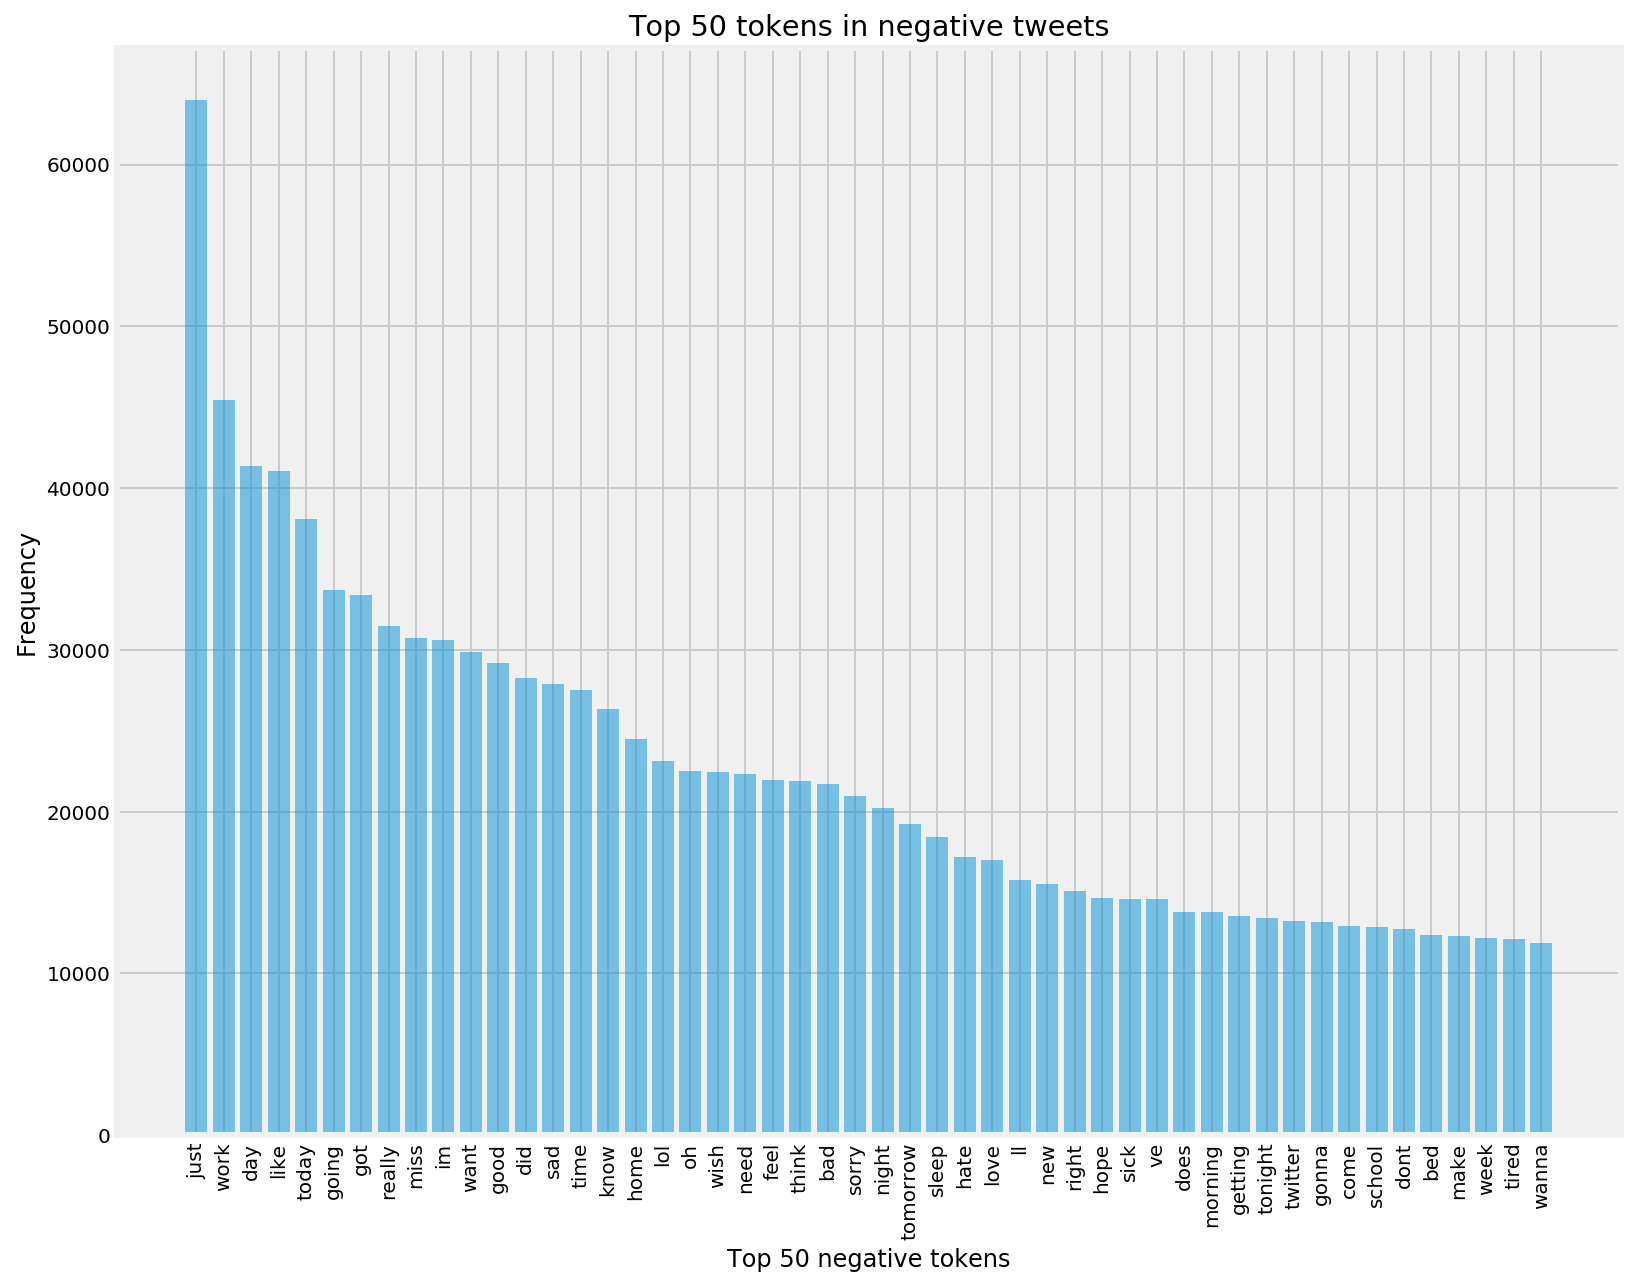

In [37]:
y_pos = np.arange(50)
plt.figure(figsize=(12,10))
plt.bar(y_pos, term_freq_df2.sort_values(by='negative', ascending=False)['negative'][:50], align='center', alpha=0.5)
plt.xticks(y_pos, term_freq_df2.sort_values(by='negative', ascending=False)['negative'][:50].index,rotation='vertical')
plt.ylabel('Frequency')
plt.xlabel('Top 50 negative tokens')
plt.title('Top 50 tokens in negative tweets')

This was to help see that words are popular in negative tweets. However, some of the most common words were "just" and "day". These are neutral. Thus, it is hard to say with these results what words characterize negative tweets.

Now, let's do the same analysis with 50 positive tokens.

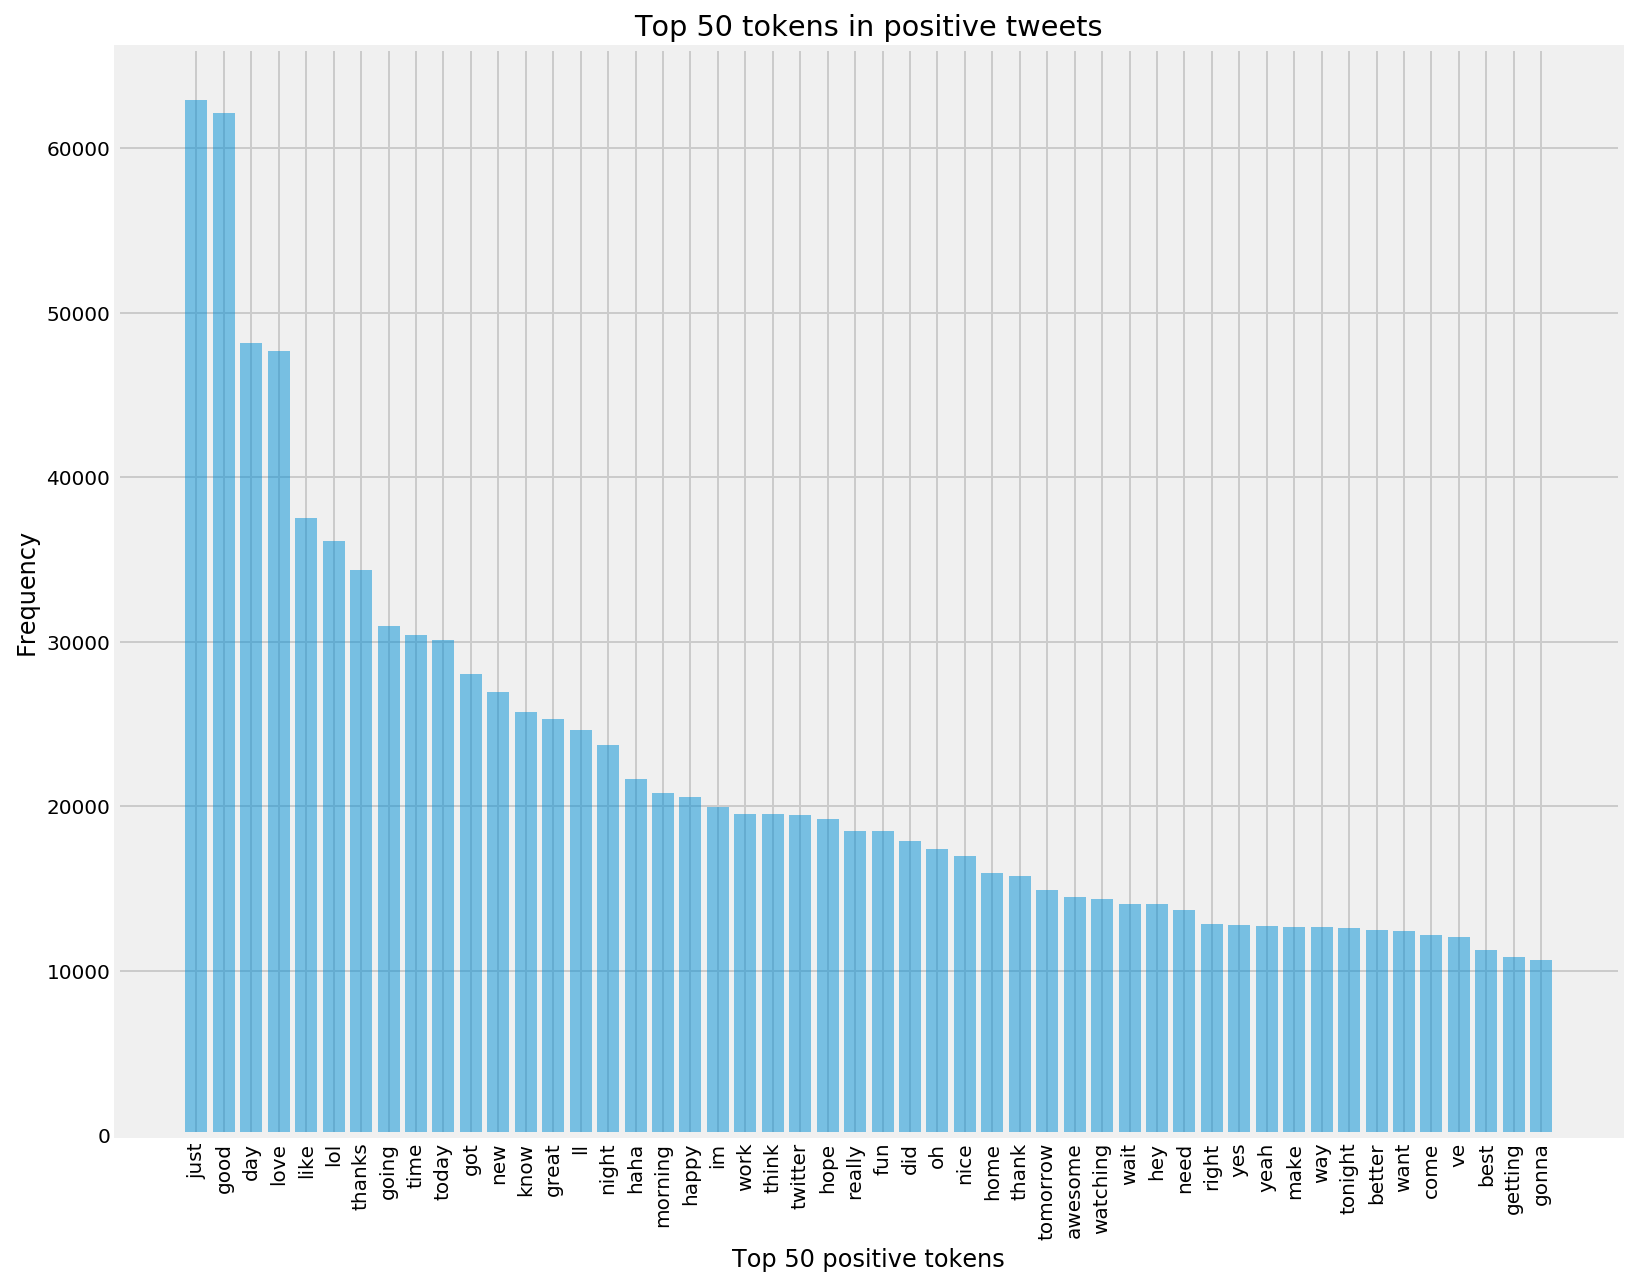

In [38]:
y_pos = np.arange(50)
plt.figure(figsize=(12,10))
plt.bar(y_pos, term_freq_df2.sort_values(by='positive', ascending=False)['positive'][:50], align='center', alpha=0.5)
plt.xticks(y_pos, term_freq_df2.sort_values(by='positive', ascending=False)['positive'][:50].index,rotation='vertical')
plt.ylabel('Frequency')
plt.xlabel('Top 50 positive tokens')
plt.title('Top 50 tokens in positive tweets')

Once again , neutral words "just" and "day" show up as the top tokens. 

In order to see how similar tokens are between negative and positive tweets. Plot of negative frequency of work on X-axis and positive frequency on Y-axis.

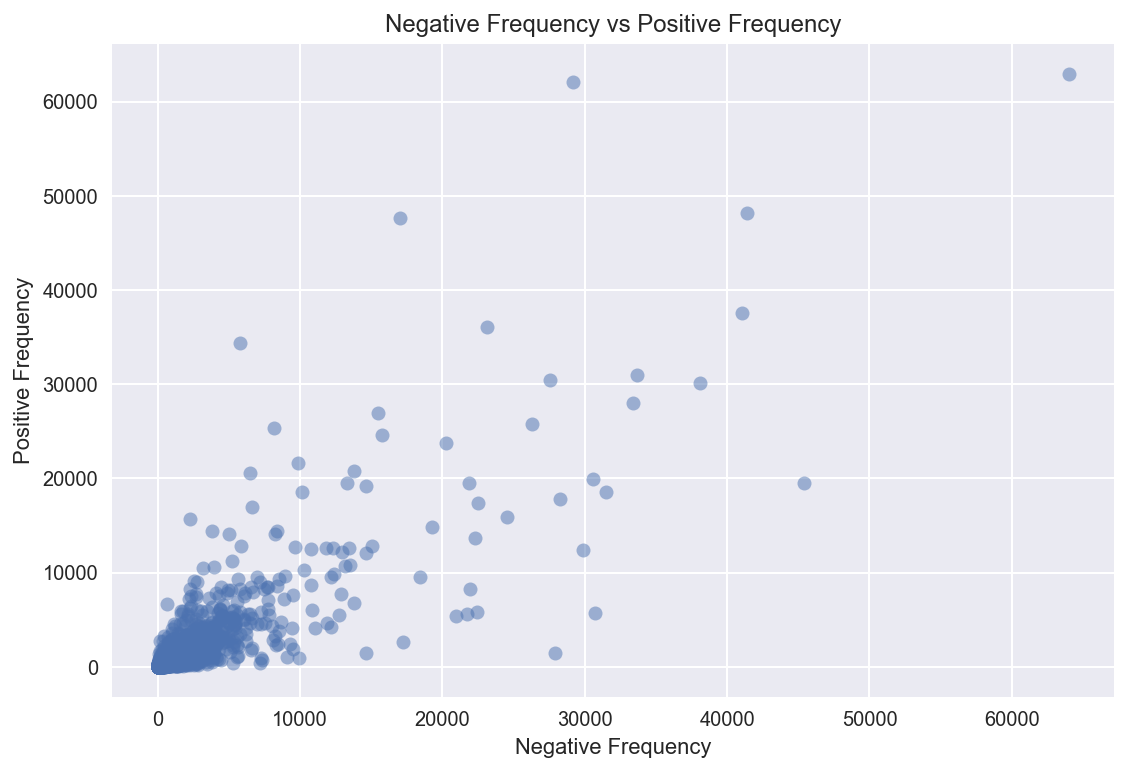

In [39]:
import seaborn as sns
plt.figure(figsize=(8,6))
ax = sns.regplot(x="negative", y="positive",fit_reg=False, scatter_kws={'alpha':0.5},data=term_freq_df2)
plt.ylabel('Positive Frequency')
plt.xlabel('Negative Frequency')
plt.title('Negative Frequency vs Positive Frequency')

Most of the words that have a relationship have a frequency below 10000. Given the non-linear relationship, not much can be said about positive frequency versus negative frequency.  

In order to better characterize important tokens within each class, a metric from Jason Kessler's PyData 2017 Seattle talk, presented a Python library called Scattertext. The metrics used in the Scattertext is a way of visualizing text data is useful in filtering meaningful tokens from the frequency data.

Intuitively, if a word appears more often in one class compared to another, this can be a good measure of how much the word is **meaningful to characterize the class**.
In the below code I named it as 'pos_rate', and as you can see from the calculation of the code,
this is defined as
$${pos\_rate} = \frac{positive\ frequency} {positive\ frequency + negative\ frequency}$$

In [41]:
term_freq_df2['pos_rate'] = term_freq_df2['positive'] * 1./term_freq_df2['total']
term_freq_df2.sort_values(by='pos_rate', ascending=False).iloc[:10]

,negative,positive,total,pos_rate
mileymonday,0,161,161,1.000000
dividends,0,83,83,1.000000
emailunlimited,0,100,100,1.000000
shareholder,1,80,81,0.987654
fuzzball,2,99,101,0.980198
recommends,3,109,112,0.973214
delongeday,6,162,168,0.964286
atcha,3,80,83,0.963855
timestamp,3,68,71,0.957746
shaundiviney,4,89,93,0.956989


Words with highest pos_rate frequency have zero neg_rate frequency, but overall frequency of these words compared to overall corpus size is insignificanct for this to be considered as a guideline for positive tweets. 

Another metric to consider is the frequency a word occurs in the class. The formula follows:
$${pos\_freq\_pct} = \frac {positive\ frequency} {\Sigma positive\ frequency}$$

In [43]:
term_freq_df2['pos_freq_pct'] = term_freq_df2['positive'] * 1./term_freq_df2['positive'].sum()
term_freq_df2.sort_values(by='pos_freq_pct', ascending=False).iloc[:10]

,negative,positive,total,pos_rate,pos_freq_pct
just,64004,62944,126948,0.495825,0.014396
good,29209,62118,91327,0.680171,0.014207
day,41374,48186,89560,0.538030,0.011021
love,16990,47694,64684,0.737338,0.010908
like,41050,37520,78570,0.477536,0.008581
lol,23123,36118,59241,0.609679,0.008261
thanks,5768,34375,40143,0.856314,0.007862
going,33689,30939,64628,0.478724,0.007076
time,27526,30432,57958,0.525070,0.006960
today,38116,30100,68216,0.441245,0.006884


But since pos_freq_pct is just the frequency scaled over the total sum of the frequency, the rank of pos_freq_pct is exactly same as just the positive frequency.

What we can do now is to combine pos_rate, pos_freq_pct together to come up with a metric which reflects both pos_rate and pos_freq_pct. Even though both of these can take a value ranging from 0 to 1, pos_rate has much wider range actually spanning from 0 to 1, while all the pos_freq_pct values are squashed within the range smaller than 0.015. If we average these two numbers, pos_rate will be too dominant, and will not reflect both metrics effectively.

So here we use harmonic mean instead of arithmetic mean. "Since the harmonic mean of a list of numbers tends strongly toward the least elements of the list, it tends (compared to the arithmetic mean) to mitigate the impact of large outliers and aggravate the impact of small ones."
The harmonic mean H of the positive real number x1,x2,...xn is defined as
$${H} = \frac {n}{\sum_{i=1}^{n}\ \frac{1}{x_i}}$$

In [46]:
from scipy.stats import hmean

term_freq_df2['pos_hmean'] = term_freq_df2.apply(lambda x: (hmean([x['pos_rate'], x['pos_freq_pct']])
                                                                   if x['pos_rate'] > 0 and x['pos_freq_pct'] > 0 
                                                                   else 0), axis=1)                                                        
term_freq_df2.sort_values(by='pos_hmean', ascending=False).iloc[:10]

,negative,positive,total,pos_rate,pos_freq_pct,pos_hmean
just,64004,62944,126948,0.495825,0.014396,0.027980
good,29209,62118,91327,0.680171,0.014207,0.027833
day,41374,48186,89560,0.538030,0.011021,0.021599
love,16990,47694,64684,0.737338,0.010908,0.021498
like,41050,37520,78570,0.477536,0.008581,0.016860
lol,23123,36118,59241,0.609679,0.008261,0.016300
thanks,5768,34375,40143,0.856314,0.007862,0.015581
going,33689,30939,64628,0.478724,0.007076,0.013946
time,27526,30432,57958,0.525070,0.006960,0.013738
today,38116,30100,68216,0.441245,0.006884,0.013557


The harmonic mean result looks like that of pos_freq_pct. This means that harmonic mean aggravated small value, pos_freq_pct too much, so much so that it dominated the mean value. The result is the same frequency rank as before and therefore provides no new insight. 

What we can try next is to get the CDF (Cumulative Distribution Function) value of both pos_rate and pos_freq_pct.
CDF can be explained as "distribution function of X, evaluated at x, is the probability that X will take a value less than or equal to x". By calculating CDF value, we can see where the value of either pos_rate or pos_freq_pct lies in the distribution in terms of cumulative manner. In the below result of the code, we can see a word "welcome" with pos_rate_normcdf of 0.995625, and pos_freq_pct_normcdf of 0.999354. This means roughly 99.56% of the tokens will take a pos_rate value less than or equal to 0.91535, and 99.99% will take a pos_freq_pct value less than or equal to 0.001521.

Next, we calculate a harmonic mean of these two CDF values, as we did earlier.
By calculating the harmonic mean, we can see that pos_normcdf_hmean metric provides a more meaningful measure of how important a word is within the class.

In [47]:
from scipy.stats import norm
def normcdf(x):
    return norm.cdf(x, x.mean(), x.std())

term_freq_df2['pos_rate_normcdf'] = normcdf(term_freq_df2['pos_rate'])
term_freq_df2['pos_freq_pct_normcdf'] = normcdf(term_freq_df2['pos_freq_pct'])
term_freq_df2['pos_normcdf_hmean'] = hmean([term_freq_df2['pos_rate_normcdf'], term_freq_df2['pos_freq_pct_normcdf']])
term_freq_df2.sort_values(by='pos_normcdf_hmean', ascending=False).iloc[:10]

,negative,positive,total,pos_rate,pos_freq_pct,pos_hmean,pos_rate_normcdf,pos_freq_pct_normcdf,pos_normcdf_hmean
welcome,620,6702,7322,0.915324,0.001533,0.003061,0.995624,0.999369,0.997493
thank,2282,15736,18018,0.873349,0.003599,0.007168,0.990791,1.000000,0.995374
thanks,5768,34375,40143,0.856314,0.007862,0.015581,0.987769,1.000000,0.993847
awesome,3821,14469,18290,0.791088,0.003309,0.006591,0.967032,1.000000,0.983240
glad,2273,8255,10528,0.784100,0.001888,0.003767,0.963660,0.999971,0.981480
follow,2552,9154,11706,0.781992,0.002094,0.004176,0.962589,0.999996,0.980936
enjoy,1642,5876,7518,0.781591,0.001344,0.002683,0.962383,0.997441,0.979598
sweet,1610,5646,7256,0.778115,0.001291,0.002578,0.960552,0.996331,0.978115
yay,3165,10501,13666,0.768403,0.002402,0.004788,0.955052,1.000000,0.977009
hello,1122,4524,5646,0.801275,0.001035,0.002067,0.971483,0.982293,0.976858


Next step is to apply the same calculation to negative frequency of each word.

In [48]:
term_freq_df2['neg_rate'] = term_freq_df2['negative'] * 1./term_freq_df2['total']
term_freq_df2['neg_freq_pct'] = term_freq_df2['negative'] * 1./term_freq_df2['negative'].sum()
term_freq_df2['neg_hmean'] = term_freq_df2.apply(lambda x: (hmean([x['neg_rate'], x['neg_freq_pct']])
                                                                   if x['neg_rate'] > 0 and x['neg_freq_pct'] > 0 
                                                                   else 0), axis=1)                                                        
term_freq_df2['neg_rate_normcdf'] = normcdf(term_freq_df2['neg_rate'])
term_freq_df2['neg_freq_pct_normcdf'] = normcdf(term_freq_df2['neg_freq_pct'])
term_freq_df2['neg_normcdf_hmean'] = hmean([term_freq_df2['neg_rate_normcdf'], term_freq_df2['neg_freq_pct_normcdf']])
term_freq_df2.sort_values(by='neg_normcdf_hmean', ascending=False).iloc[:10]

,negative,positive,total,pos_rate,pos_freq_pct,pos_hmean,pos_rate_normcdf,pos_freq_pct_normcdf,pos_normcdf_hmean,neg_rate,neg_freq_pct,neg_hmean,neg_rate_normcdf,neg_freq_pct_normcdf,neg_normcdf_hmean
sad,27911,1510,29421,0.051324,0.000345,0.000686,0.002388,0.709591,0.004761,0.948676,0.006096,0.012114,0.997612,1.000000,0.998804
hurts,7204,456,7660,0.059530,0.000104,0.000208,0.002803,0.503854,0.005574,0.940470,0.001573,0.003142,0.997197,0.999742,0.998468
sick,14617,1419,16036,0.088488,0.000325,0.000647,0.004832,0.693343,0.009598,0.911512,0.003192,0.006363,0.995168,1.000000,0.997578
sucks,9902,982,10884,0.090224,0.000225,0.000448,0.004988,0.610419,0.009895,0.909776,0.002163,0.004315,0.995012,0.999999,0.997499
poor,7333,719,8052,0.089295,0.000164,0.000328,0.004904,0.557659,0.009723,0.910705,0.001602,0.003198,0.995096,0.999799,0.997442
ugh,9056,998,10054,0.099264,0.000228,0.000455,0.005873,0.613574,0.011634,0.900736,0.001978,0.003947,0.994127,0.999995,0.997053
missing,7282,991,8273,0.119787,0.000227,0.000452,0.008415,0.612195,0.016602,0.880213,0.001590,0.003175,0.991585,0.999778,0.995665
headache,5317,421,5738,0.073371,0.000096,0.000192,0.003650,0.496667,0.007247,0.926629,0.001161,0.002320,0.996350,0.993811,0.995079
hate,17207,2614,19821,0.131880,0.000598,0.001190,0.010328,0.868740,0.020413,0.868120,0.003758,0.007484,0.989672,1.000000,0.994809
miss,30713,5676,36389,0.155981,0.001298,0.002575,0.015295,0.996497,0.030127,0.844019,0.006708,0.013310,0.984705,1.000000,0.992294


Now let's see how the values are converted on a plot. In order to compare, I will first plot neg_hmean vs pos_hmean, and neg_normcdf_hmean vs pos_normcdf_hmean.

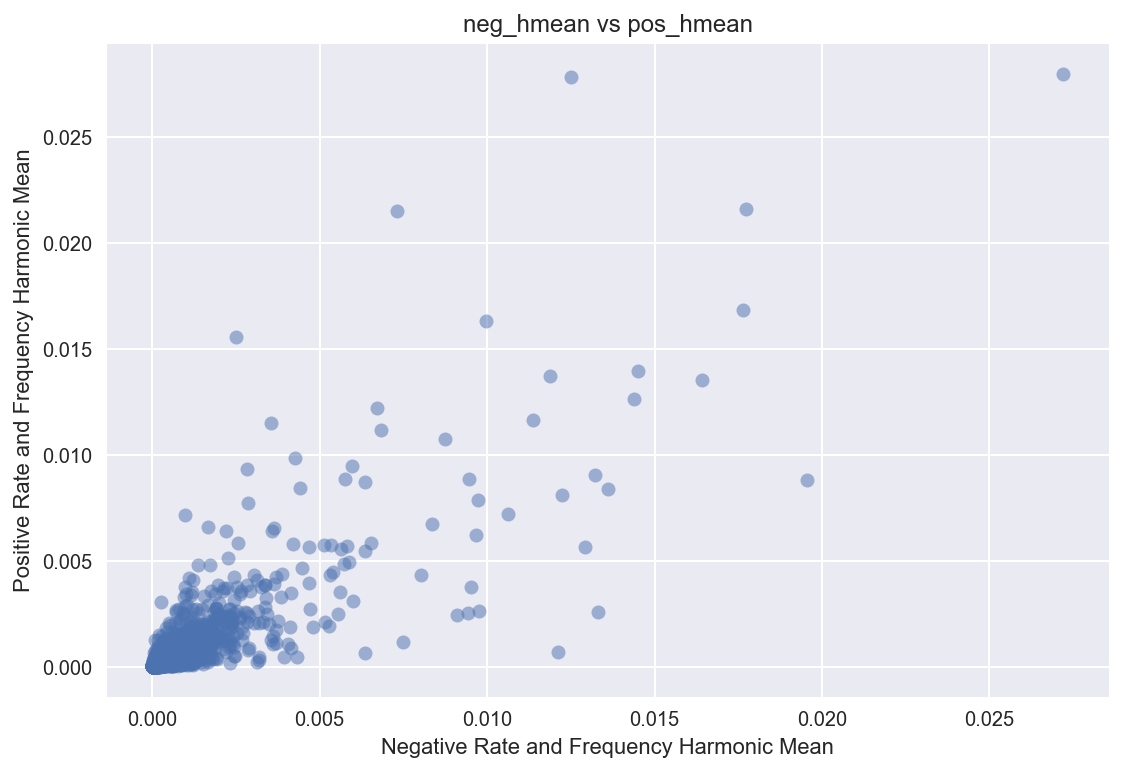

In [51]:
plt.figure(figsize=(8,6))
ax = sns.regplot(x="neg_hmean", y="pos_hmean",fit_reg=False, scatter_kws={'alpha':0.5},data=term_freq_df2)
plt.ylabel('Positive Rate and Frequency Harmonic Mean')
plt.xlabel('Negative Rate and Frequency Harmonic Mean')
plt.title('neg_hmean vs pos_hmean')

Not much difference from just the frequency of positive and negative. How about the CDF harmonic mean?

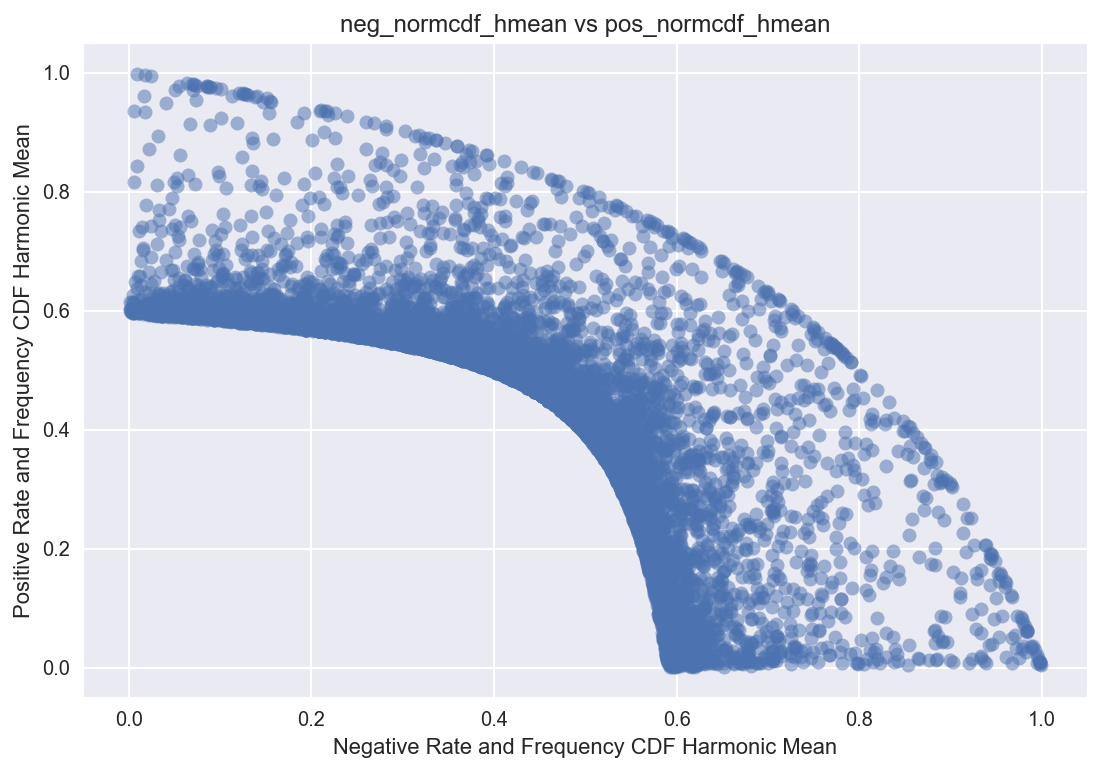

In [52]:
plt.figure(figsize=(8,6))
ax = sns.regplot(x="neg_normcdf_hmean", y="pos_normcdf_hmean",fit_reg=False, scatter_kws={'alpha':0.5},data=term_freq_df2)
plt.ylabel('Positive Rate and Frequency CDF Harmonic Mean')
plt.xlabel('Negative Rate and Frequency CDF Harmonic Mean')
plt.title('neg_normcdf_hmean vs pos_normcdf_hmean')

It seems like the harmonic mean of rate CDF and frequency CDF has created an interesting pattern on the plot. If a data point is near to upper left corner, it is more positive. And if a point is closer to the bottom right corner, it is more negative.

It is good that the metric has created some meaningful insight out of frequency, but with text data, showing every token as just a dot is lacking important information on which token each data point represents. With 10,000 points, it is difficult to annotate all of the points on the plot. For this part, I have tried several methods and came to a conclusion that it is not very practical or feasible to directly annotate data points on the plot.

So I took an alternative method using the interactive plot with Bokeh. Bokeh is an interactive visualization library for Python, which creates graphics in style of D3.js. Bokeh can output the result in HTML format or also within the Jupyter Notebook. What follows is the plot created using Bokeh library.

In [53]:
from bokeh.plotting import figure
from bokeh.io import output_notebook, show
from bokeh.models import LinearColorMapper
output_notebook()
color_mapper = LinearColorMapper(palette='Inferno256', low=min(term_freq_df2.pos_normcdf_hmean), high=max(term_freq_df2.pos_normcdf_hmean))
p = figure(x_axis_label='neg_normcdf_hmean', y_axis_label='pos_normcdf_hmean')
p.circle('neg_normcdf_hmean','pos_normcdf_hmean',size=5,alpha=0.3,source=term_freq_df2,color={'field': 'pos_normcdf_hmean', 'transform': color_mapper})
from bokeh.models import HoverTool
hover = HoverTool(tooltips=[('token','@index')])
p.add_tools(hover)
show(p)

Loading BokehJS ...

With the above Bokeh plot, you can see what token each data point represents by hovering over the points. For example, the points in the top left corner show tokens like "thank", "welcome", "congrats", etc. And some of the tokens in bottom right corner are "sad", "hurts", "died", "sore", etc. And the colour of each dot is organized in "Inferno256" colour map in Python. So yellow is the most positive, while black is the most negative, and the colour gradually goes from black to purple to orange to yellow, as it goes from negative to positive.